Semi-discrete Optimal Transport
===============================

$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Yy}{\mathcal{Y}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$
$\newcommand{\eqdef}{\equiv}$

This numerical tour studies semi-discrete optimal transport, i.e. when
one of the two measure is discrete. 

The initial papers that proposed this approach are [Oliker89,Aurenhammer98]. We refer to [Mérigot11,Lévy15] for modern references and fast implementations.

This tour is not inteded to show efficient
algorithm but only conveys the main underlying idea (c-transform,
Laguerre cells, connexion to optimal quantization).
In the Euclidean case, there exists efficient algorithm to compute
Laguerre cells leveraging computational geometry algorithm for convex
hulls [Aurenhammer87].

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Dual OT and c-transforms
------------------------
The primal Kantorovitch OT problem reads
$$ W_c(\al,\be) = \umin{\pi} \enscond{\int_{\Xx \times \Yy} c(x,y) \text{d}\pi(x,y)}{ \pi_1=\al,\pi_2=\be }.  $$
It dual is
$$ W_c(\al,\be) = \umax{f,g} \enscond{ \int_\Xx f \text{d} \al + \int_\Yy g \text{d} \be }{ f(x)+g(y) \leq c(x,y) }. $$


We consider the case where $\al=\sum_i a_i \de_{x_i}$ is a discrete
measure, so that the function $f(x)$ can be replaced by a vector
$(f_i)_{i=1}^n \in \RR^n$. The optimal $g(y)$ function can the be
replaced by the $c$-transform of $f$
$$ f^c(y) \eqdef \umin{i} c(x_i,y) - f_i.  $$


The function to maximize is then
$$  W_c(\al,\be) = \umax{f \in \RR^n} \Ee(f) \eqdef \sum_i f_i a_i + \int f^c(y) \text{d}\be(y). $$

Semi-discret via Gradient Ascent
--------------------------------
We now implement a gradient ascent scheme for the maximization of
$\Ee$. The evaluation of $\Ee$)  can be computed via the introduction
of the partition of the domain in Laguerre cells
$$ \Yy = \bigcup_{i} L_i(f) \qwhereq L_i(f) \eqdef \enscond{y}{ \forall j,
     c(x_i,y) - f_i \leq c(x_j,y) - f_j }.  $$
When $f=0$, this corrsponds to the partition in Voronoi cells.


One has that $\forall y \in L_i(f)$, $f^c(y) = c(x_i,y) - f_i$, i.e. $f^c$ is piecewise smooth
according to this partition.


The grid for evaluation of the "continuous measure".

In [2]:
p = 300 # size of the image for sampling, m=p*p
t = np.linspace(0,1,p)
[V,U] = np.meshgrid(t,t)
Y = np.concatenate( (U.flatten()[None,:], V.flatten()[None,:] ) )

First measure, sums of Dirac masses $\al = \sum_{i=1}^n a_i \de_{x_i}$.

In [3]:
n = 30;
X = .5+.5j + np.exp(1j*np.pi/4) * 1*( .1*(np.random.rand(1,n)-.5)+1j*(np.random.rand(1,n)-.5) );
X = np.concatenate( (np.real(X),np.imag(X)) )
a = np.ones(n)/n

Second measure $\be$, potentially a continuous one (i.e. with a density),
mixture of Gaussians. Here we discretize $\beta = \sum_{j=1}^m b_j \de_{y_j}$ on a very fine grid.

In [4]:
def Gauss(mx,my,s): return np.exp( (-(U-mx)**2-(V-my)**2)/(2*s**2) )
Mx = [.6,.4] # means
My = [.9,.1]
S = [.07,.09] # variance
W = [.5,.5] # weights
b = W[0]*Gauss(Mx[0],My[0],S[0]) + W[1]*Gauss(Mx[1],My[1],S[1])
b = b/np.sum(b.flatten())

Display the two measures.

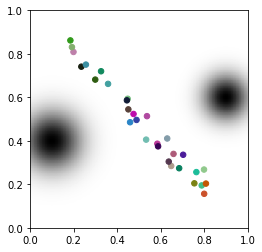

In [5]:
Col = np.random.rand(n,3)
plt.imshow(-b[::-1,:], extent=[0, 1, 0, 1], cmap='gray')
plt.scatter( X[1,:], X[0,:], s=30, c=.8*Col);

Initial potentials.

In [6]:
f = np.zeros(n)

compute Laguerre cells and c-transform

In [7]:
def distmat(x,y): return np.sum(x**2,0)[:,None] + np.sum(y**2,0)[None,:] - 2*x.transpose().dot(y)
D = distmat(Y,X) - f[:].transpose()
fC = np.min(D,axis=1)
I = np.reshape( np.argmin(D,axis=1), [p,p] )

Dual value of the OT, $\dotp{f}{a}+\dotp{f^c}{\be}$.

In [8]:
OT = np.sum(f*a) + np.sum(fC*b.flatten())
print(OT)

0.10895710129175601


Display the Laguerre call partition (here this is equal to the Vornoi
diagram since $f=0$).

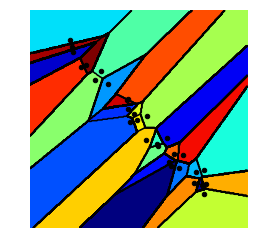

In [9]:
plt.imshow(I[::-1,:], extent=[0, 1, 0, 1], cmap='jet')
plt.scatter( X[1,:], X[0,:], s=20, c='k')
plt.contour(t,t,I, np.linspace(-.5,n-.5,n), colors='k')
plt.axis('off');

Where $\be$ has a density with respect to Lebesgue measure, then
$\Ee$ is smooth, and its gradient reads
$$ \nabla \Ee(f)_i = a_i - \int_{L_i(f)} \text{d}\be(x). $$

sum area captured

__Exercise 1__

Implement a gradient ascent
$$ f \leftarrow f + \tau \nabla \Ee(f). $$
Experiment on the impact of $\tau$, display the evolution of the OT value $\Ee$ and
of the Laguerre cells.

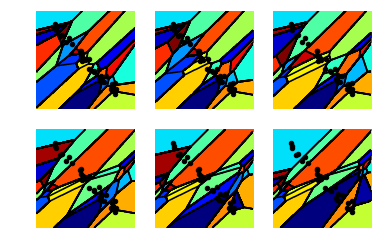

In [10]:
tau = .02; # step size
niter = 200 # iteration for the descent
q = 6 # number of displays
ndisp = np.unique( np.round( 1 + (niter/4-1)*np.linspace(0,1,q)**2 ) )
kdisp = 0
f = np.zeros(n)
E = np.zeros(niter)
for it in range(niter):
    # compute Laguerre cells and c-transform
    D = distmat(Y,X) - f[:].transpose()
    fC = np.min(D,axis=1)
    I = np.reshape( np.argmin(D,axis=1), [p,p] )
    E[it] = np.sum(f*a) + np.sum(fC*b.flatten())   
    # display
    if (kdisp<len(ndisp)) and (ndisp[kdisp]==it):
        plt.subplot(2,3,kdisp+1)
        plt.imshow(I[::-1,:], extent=[0, 1, 0, 1], cmap='jet')
        plt.scatter( X[1,:], X[0,:], s=20, c='k')
        plt.contour(t,t,I, np.linspace(-.5,n-.5,n), colors='k')
        plt.axis('off')
        kdisp = kdisp+1;
    # gradient
    R = ( I[:,:,None] == np.arange(0,n)[None,None,:] ) * b[:,:,None]
    nablaE = a-np.sum(R, axis=(0,1)).flatten()
    f = f+tau*nablaE

Display the evolution of the estimated OT distance.

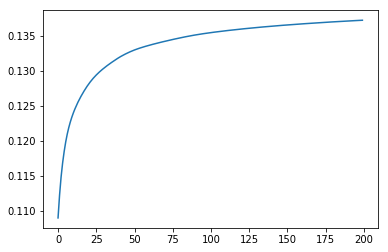

In [11]:
plt.plot(E, '-');

Stochastic Optimization
-----------------------
The function $\Ee$ to minimize can be written as an expectation over a
random variable $Y \sim \be$
$$ \Ee(f)=\EE(E(f,Y)) \qwhereq E(f,y) = \dotp{f}{a} + f^c(y).  $$


As proposed in [Genevay16], one can thus use a stochastic gradient ascent scheme to minimize this
function, at iteration $\ell$
$$ f \leftarrow f + \tau_\ell \nabla E(f,y_\ell)  $$
where $y_\ell \sim Y$ is a sample drawn according to $\be$ and the
step size $\tau_\ell \sim 1/\ell$ should decay at a carefully chosen
rate.


The gradient of the integrated functional reads
$$ \nabla E(f,y)_i = a - 1_{L_i(f)}(y),  $$
where $1_A$ is the binary indicator function of a set $A$.


Initialize the algorithm.

In [12]:
f = np.zeros(n)

Draw the sample.

In [13]:
k = np.int(np.random.rand(1)<W[1]) # select one of the two Gaussian
y = np.array( (S[k] * np.random.randn(1) + Mx[k], S[k] * np.random.randn(1) + My[k]) )

Compute the randomized gradient: detect Laguerre cell where $y$ is.

In [14]:
R = np.sum(y**2) + np.sum(X**2, axis=0) - 2*y.transpose().dot(X) - f[:]
i = np.argmin( R )

Randomized gradient.

In [15]:
a = np.ones(n)/n
nablaEy = a.copy()
nablaEy[i] = nablaEy[i] - 1

__Exercise 2__

Implement the stochastic gradient descent.
Test various step size selection rule.

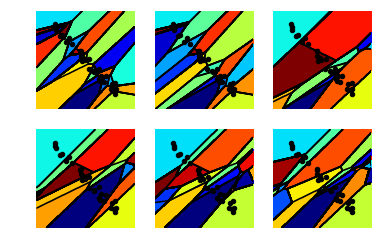

In [16]:
niter = 300
q = 6
ndisp = np.unique( np.round( 1 + (niter/2-1)*np.linspace(0,1,q)**2 ) )
kdisp = 0
E = np.zeros(niter)
for it in range(niter):
    # sample
    k = np.int(np.random.rand(1)<W[1]) # select one of the two Gaussian
    y = np.array( (S[k] * np.random.randn(1) + Mx[k], S[k] * np.random.randn(1) + My[k]) )
    # detect Laguerre cell where y is
    R = np.sum(y**2) + np.sum(X**2, axis=0) - 2*y.transpose().dot(X) - f[:]
    i = np.argmin( R )
    # gradient
    nablaEy = a.copy()
    nablaEy[i] = nablaEy[i] - 1
    # gradient ascent
    l0 = 10; # warmup phase.
    tau = .1/( 1 + it/l0 )
    f = f + tau*nablaEy    
    # compute Laguerre cells and c-transform
    D = distmat(Y,X) - f[:].transpose()
    fC = np.min(D,axis=1)
    I = np.reshape( np.argmin(D,axis=1), [p,p] )
    E[it] = np.sum(f*a) + np.sum(fC*b.flatten())    
    # display
    if (kdisp<len(ndisp)) and (ndisp[kdisp]==it):
        plt.subplot(2,3,kdisp+1)
        plt.imshow(I[::-1,:], extent=[0, 1, 0, 1], cmap='jet')
        plt.scatter( X[1,:], X[0,:], s=20, c='k')
        plt.contour(t,t,I, np.linspace(-.5,n-.5,n), colors='k')
        plt.axis('off')
        kdisp = kdisp+1

Display the evolution of the estimated OT distance (warning: recording this
takes lot of time).

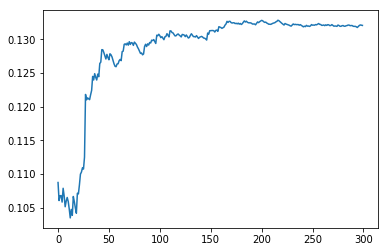

In [17]:
plt.plot(E);

Optimal Quantization and Lloyd Algorithm
----------------------------------------
We consider the following optimal quantization problem [Gruber02]
$$ \umin{ (a_i)_i,(x_i)_i } W_c\pa{ \sum_i a_i \de_{x_i},\be }.  $$
This minimization is convex in $a$, and writing down the optimality
condition, one has that the associated dual potential should be $f=0$,
which means that the associated optimal Laguerre cells should be Voronoi
cells $L_i(0)=V_i(x)$ associated to the sampling locations
$$ V_i(x) = \enscond{y}{ \forall j, c(x_i,y) \leq c(x_j,y) }. $$

This problem is tightly connected to semi-discrete OT, and this connexion and its implications are studied in [Canas12].

The minimization is non-convex with respect to the positions
$x=(x_i)_i$ and one needs to solve
$$ \umin{x} \Ff(x) \eqdef \sum_{i=1}^n \int_{V_i(x)} c(x_i,y) \text{d} \be(y). $$
For the sake of simplicity, we consider the case where
$c(x,y)=\frac{1}{2}\norm{x-y}^2$.


The gradient reads
$$ \nabla \Ff(x)_i = x_i \int_{V_i(x)} \text{d}\be  - \int_{V_i(x)} y \text{d}\be(y).  $$
The usual algorithm to compute stationary point of this energy is Lloyd's algorithm [Lloyd82], which
iterate the fixed point
$$ x_i \leftarrow \frac{ \int_{V_i(x)} y \text{d}\be(y) }{  \int_{V_i(x)} \text{d}\be },  $$
i.e. one replaces the centroids by the barycenter of the cells.


Intialize the centroids positions.

In [18]:
X1 = X.copy()

Compute the Voronoi cells $V_i(x)$.

In [19]:
D = D = distmat(Y,X1)
fC = np.min(D,axis=1)
I = np.reshape( np.argmin(D,axis=1), [p,p] )

Update the centroids to the barycenters.

In [20]:
A = ( I[:,:,None] == np.arange(0,n)[None,None,:] ) * b[:,:,None]
B = ( I[:,:,None] == np.arange(0,n)[None,None,:] ) * b[:,:,None] * ( U[:,:,None] + 1j*V[:,:,None] )
X1 = np.sum(B,axis=(0,1)) / np.sum(A,axis=(0,1))
X1 = np.concatenate( (np.real(X1)[None,:], np.imag(X1)[None,:]) )

__Exercise 3__

Implement Lloyd algortihm.

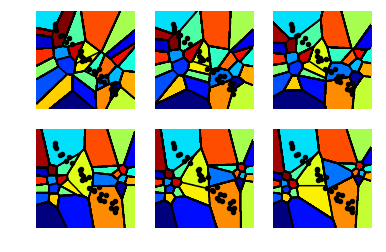

In [21]:
niter = 60
q = 6
ndisp = np.unique( np.round( 1 + (niter/4-1)*np.linspace(0,1,q)**2 ) )
kdisp = 0
E = np.zeros(niter)
X1 = X.copy()
for it in range(niter):
    # compute Voronoi cells
    D = D = distmat(Y,X1)
    fC = np.min(D,axis=1)
    I = np.reshape( np.argmin(D,axis=1), [p,p] )
    E[it] = np.sum(fC*b.flatten())
    # display
    if (kdisp<len(ndisp)) and (ndisp[kdisp]==it):
        plt.subplot(2,3,kdisp+1)
        plt.imshow(I[::-1,:], extent=[0, 1, 0, 1], cmap='jet')
        plt.scatter( X[1,:], X[0,:], s=20, c='k')
        plt.contour(t,t,I, np.linspace(-.5,n-.5,n), colors='k')
        plt.axis('off')
        kdisp = kdisp+1
    # update barycenter    
    A = ( I[:,:,None] == np.arange(0,n)[None,None,:] ) * b[:,:,None]
    B = ( I[:,:,None] == np.arange(0,n)[None,None,:] ) * b[:,:,None] * ( U[:,:,None] + 1j*V[:,:,None] )
    X1 = np.sum(B,axis=(0,1)) / np.sum(A,axis=(0,1))
    X1 = np.concatenate( (np.real(X1)[None,:], np.imag(X1)[None,:]) )

Display the evolution of the estimated OT distance.

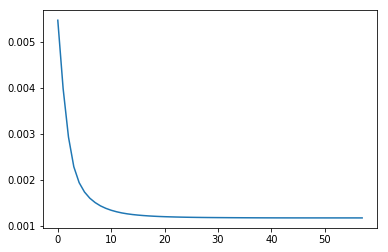

In [22]:
plt.plot(E[1:-1]);

References
----------
* [Oliker89] Vladimir Oliker and Laird D Prussner. _On the numerical solution of the equation $\frac{\partial^2 z}{\partial x^2} \frac{\partial^2 z}{\partial y^2} - \pa{\frac{\partial^2 z}{\partial x\partial y}}^2 = f$ and its discretizations_, I. Numerische Mathematik, 54(3):271-293, 1989.
* [Aurenhammer98] Franz Aurenhammer, Friedrich Hoffmann and Boris Aronov. _Minkowski-type theorems and least-squares clustering_. Algorithmica, 20(1):61-76, 1998.
* [Mérigot11] Quentin Mérigot. _A multiscale approach to optimal transport_. Comput. Graph. Forum, 30(5):1583-1592, 2011.
* [Lévy15] Bruno Lévy. _A numerical algorithm for l2 semi-discrete optimal transport in 3D_. ESAIM: Mathematical Modelling and Numerical Analysis, 49(6):1693-1715, 2015.
* [Aurenhammer87] Franz Aurenhammer. _Power diagrams: properties, algorithms and applications_. SIAM Journal on Computing, 16(1):78-96, 1987.
* [Canas12] Guillermo Canas, Lorenzo Rosasco, _Learning probability measures with respect to optimal transport metrics_. In Advances in Neural Information Processing Systems, pp. 2492--2500, 2012.
* [Gruber02] Peter M. Gruber. _Optimum quantization and its applications_. Adv. Math, 186:2004, 2002.
* [Lloyd82] Stuart P. Lloyd, _Least squares quantization in PCM_, IEEE Transactions on Information Theory, 28 (2): 129-137, 1982.
* [Genevay16] Aude Genevay, Marco Cuturi, Gabriel Peyré and Francis Bach. _Stochastic oppmization for large-scale optimal transport_. In Advances in Neural Information Processing Systems, pages 3440-3448, 2016.